<a href="https://colab.research.google.com/github/el-geuse/EE992/blob/main/base_project_verpeter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hi Peter, so right now I think that the key stuff is to try testing a different model type. I hadn't yet tested the other model types aside from VGG16 - too busy getting the batch size and learning rate and the other changes to work for the setup. I recommend trying them:

**Sounds good, I'll do some model testing. Planning to check out Efficientnet since I heard it was good.**

Frozen backbone:

batch_size = 256,
learning rate = 0.01 with less than 5 epochs or 0.001 and about 10 epochs

Unfrozen backbone:

batch_size = 256
learning rate = 1e-4 for 8-10 epochs or 1e-5 for >8 epochs (although the timeout usually ocurred to me at this point)

Otherwise, if you can adapt the ROCOF curve plotting - I only copy and pasted what was recommended from the stackoverflow answer but I think once the y_score is specific to the trained model then it'll be working fine.

**Thumbsup**

I haven't tested any of the previous models with the data augmentation code that's been written up - so potentially something to also try but pick whichever model gives the best accuracy

Also no other loss function was tested.

**Don't think we need to do any changing of the loss function, but definitely a good one to talk about yeah**

Also I'm not sure what source you used but we'll need it to explain the upscaling to (160, 160, 3)

**Yeah I'll try find the source I used from this, think it referenced a paper**

##Import necessary libraries

In [ ]:
%matplotlib inline


!cat /proc/cpuinfo # gives details of CPU

!nvidia-smi # gives details of GPU

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, GlobalMaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers


# Commonly used modules
import numpy as np
import os, datetime
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)


from matplotlib.pyplot import imshow

from keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs mmio_stale_data retbleed
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtua

##Load CIFAR100 dataset

In [ ]:
from keras.datasets import cifar100
(x_train, y_train), (X_test, Y_test)  = cifar100.load_data()

# return the modified images
print("Train Images shape: ",x_train.shape)
print("Test Images shape: ",X_test.shape)
print(y_train.shape)
print(Y_test.shape)

169001437/169001437 [==============================] - 3s 0us/step
Train Images shape:  (50000, 32, 32, 3)
Test Images shape:  (10000, 32, 32, 3)
(50000, 1)
(10000, 1)


# Train Validation Split
Splitting the training data up into both validation and testing data. Useful to have some validation data to allow for tuning of hyperparameters. Using StratifiedShuffleSplit as 500 images for eqch class has a small chance to skew it, so ensuring stratification is vital.

In [2]:

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)

for train_index, val_index in st.split(x_train, y_train):
    X_train, X_val, Y_train, Y_val = x_train[train_index], x_train[val_index], y_train[train_index], y_train[val_index]

print("Train Images shape: ",X_train.shape)
print("Validation Images shape: ",X_val.shape)

##Preprocess Image Data

In [ ]:
def preprocess_images(X, Y): # should work for both a single image and multiple images
    X_p = keras.applications.densenet.preprocess_input(X) # what does this do?
    Y_p = keras.utils.to_categorical(Y, 100)
    return X_p, Y_p

# preprocess the train images
x_train, y_train = preprocess_images(x_train, y_train)

# preprocess the test images
x_test, y_test = preprocess_images(x_test, y_test)

Need to explain this block in the report - key thing is the function which scales down the typical pixel values (0 to 255) to be between 0 and 1

## Data Augmentation

In [ ]:
# data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal_and_vertical"), layers.RandomRotation(0.2)])

In [ ]:
# tf.image methods where key ones include grayscale (probably would worsen the model), adjust brightness or central crop could be more interesting

## Analysing Model with frozen backbone

https://keras.io/guides/transfer_learning/

In [ ]:
# input tensor
inputs = keras.Input(shape=(32, 32, 3))

# to test with data augmentation the best version of the model yet?
# x = data_augmentation(inputs)

# upscale layer
upscale = keras.layers.Lambda(lambda x: tf.image.resize_with_pad(x,
            160,
            160,
            method=tf.image.ResizeMethod.BILINEAR))(inputs)

frozen_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_tensor=upscale,
                   input_shape=(160,160,3),
                   pooling='max')
# Might need to remove the pooling max to then compare against

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
frozen_model.trainable = False # freeze backbone

In [ ]:
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`
x = frozen_model(inputs, training=False)
# ADD layer here for the data augmentation step??

# Convert features of shape `base_model.output_shape[1:]` to vectors
# x = keras.layers.GlobalAveragePooling2D()(x)
x = frozen_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
# maybe change this to see if reducing no. of connected layers speeds up the training adn if the accuracy increases
#x = keras.layers.BatchNormalization()(x)
#x = keras.layers.Dense(64, activation='relu')(x)
#x = keras.layers.Dropout(0.3)(x)
# A Dense classifier with a 100 classes
outputs = keras.layers.Dense(100, activation='softmax')(x)

Patience means the number of epochs with no improvement after which training will be stopped.

Min_delta is the other important parameter that defines the min. change in the monitored value - again the validation accuracy to qualify as an improvement - could potentially stop it even earlier then.

In [ ]:
CALLBACKS = []
MODEL_PATH = 'Higher_Eta.h5'

# callbacks
CALLBACKS.append(keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_accuracy',
                                              save_best_only=True))

CALLBACKS.append(keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(keras.callbacks.TensorBoard(log_dir='logs'))

model = keras.models.Model(inputs, outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.01),
              metrics=['accuracy'])

history1 = model.fit(x=x_train, y=y_train,
                    batch_size=256,
                    epochs=10,
                    validation_data=(x_test, y_test),
                    callbacks=CALLBACKS)

Epoch 1/10
196/196 [==============================] - 176s 750ms/step - loss: 2.7553 - accuracy: 0.3002 - val_loss: 2.2016 - val_accuracy: 0.4146
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - 145s 740ms/step - loss: 2.2252 - accuracy: 0.4034 - val_loss: 1.9084 - val_accuracy: 0.4722
Epoch 3/10
196/196 [==============================] - 146s 748ms/step - loss: 2.0633 - accuracy: 0.4384 - val_loss: 1.8454 - val_accuracy: 0.4936
Epoch 4/10
196/196 [==============================] - 126s 645ms/step - loss: 1.9707 - accuracy: 0.4608 - val_loss: 1.8070 - val_accuracy: 0.5040
Epoch 5/10
196/196 [==============================] - 146s 746ms/step - loss: 1.9048 - accuracy: 0.4751 - val_loss: 1.8031 - val_accuracy: 0.5087
Epoch 6/10
196/196 [==============================] - 146s 748ms/step - loss: 1.8384 - accuracy: 0.4906 - val_loss: 1.8064 - val_accuracy: 0.5096
Epoch 7/10
196/196 [==============================] - 126s 645ms/step - loss: 1.8051 - accuracy: 0.4991 - val_loss: 1.7775 - val_accuracy: 0.5135
Epoch 8/10
196/196 [==============================] - 146s 744ms/step - loss: 1.7762 - accuracy: 0.5047 - val_loss: 1.7775 - val_accura

**Record the amount of time it takes to run**

In [ ]:
hist = pd.DataFrame(history1.history)
# write all of the data to excel
hist.to_excel("excel_higher_eta.xlsx", sheet_name = "Sheet1")
# doesn't record how long the training takes so either do it manually like me or figure out a way to record the computational time - good as another comparison metric

In [ ]:
model.save(MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Remember to download the excel file & model as soon as it finishes running**

Tried decreasing the no. of fully connected layers or well specifically tried to remove the final hidden layer which was smaller than the previous one. But main change was that the batch size was doubled. Epoch 8 had an accuracy of 0.4207. The new version had achieved a higher accuracy of 0.4514 by epoch 3. Did it still considerably increase after epoch 8 to epoch 10?



Answer here: Could still be tested for more epoch above 10 as the final achieved accuracy is 0.5374

When the batch size was increased from 248 to 256 at epoch 10 the accuracy is instead 0.5331 or 0.53335.

So although I expected the accuracy to be higher it begins at an accuracy of 0.1279 while the baseline model - updating as a whole starts at an accuracy of 0.0295 at epoch 1 and 0.2991 at epoch 15 which is already beaten by epoch 3 of the frozen model with an accuracy of 0.3181. It is also much faster as it is only updating the fully connected layers at the end while maintaining the backbone at the same weights which are imagenet.

Between Epoch 6-8 the frozen model training has certainly slowed down at around an accuracy of 40% which isn't that great - might need to increase the no. of neurons in the fully connected layers or increase the no. of layers.

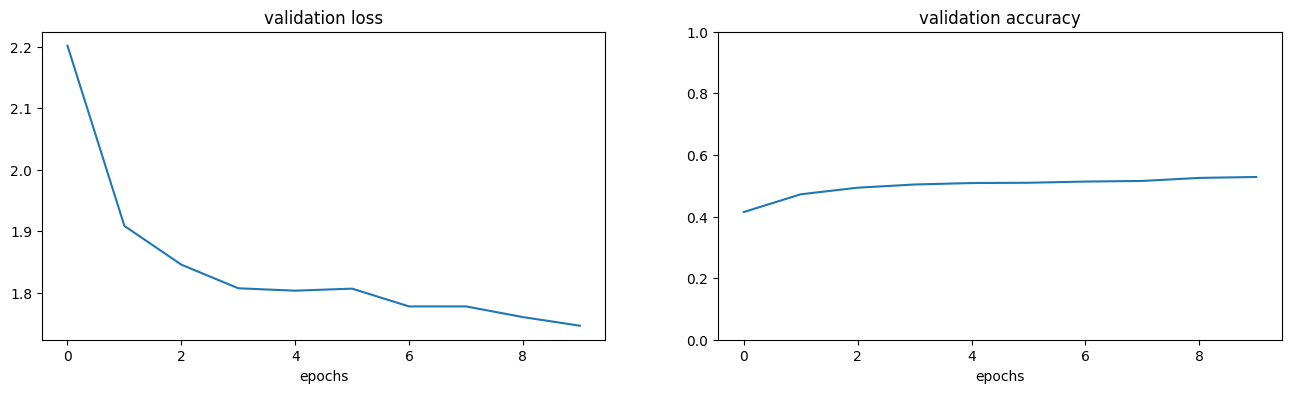

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history1.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history1.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.savefig('Frozen_Baseline_model_val_accuracy.png')
plt.show()

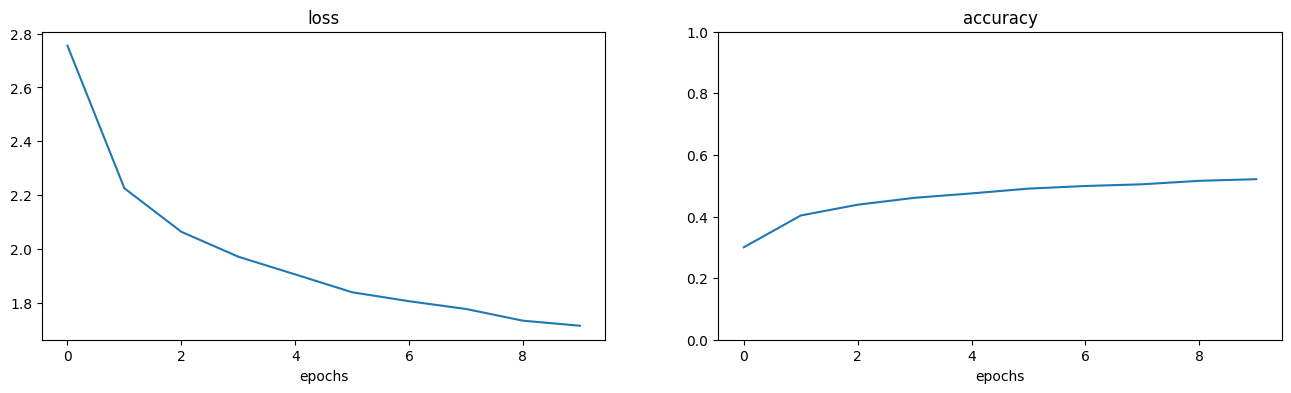

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history1.history["loss"])
ax.set_title("loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history1.history["accuracy"])
ax2.set_title("accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()
plt.savefig('Frozen_Baseline_model_accuracy.png')

Finetuning the model by maintaining a low learning rate so the weights of the backbone don't change too much eg. don't overfit or underfit the dataset

In [ ]:
# Unfreeze the base model
frozen_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-4),  # Very low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
history2 = model.fit(x=x_train, y=y_train, batch_size=256, epochs=5, validation_data=(x_test, y_test), callbacks=CALLBACKS)

Epoch 1/5
196/196 [==============================] - 384s 2s/step - loss: 0.7746 - accuracy: 0.7571 - val_loss: 1.1091 - val_accuracy: 0.6836
Epoch 2/5
196/196 [==============================] - ETA: 0s - loss: 0.6516 - accuracy: 0.7925

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - 390s 2s/step - loss: 0.6516 - accuracy: 0.7925 - val_loss: 1.0824 - val_accuracy: 0.6955
Epoch 3/5
196/196 [==============================] - 366s 2s/step - loss: 0.5588 - accuracy: 0.8187 - val_loss: 1.0510 - val_accuracy: 0.7115
Epoch 4/5
196/196 [==============================] - 364s 2s/step - loss: 0.4852 - accuracy: 0.8430 - val_loss: 1.1258 - val_accuracy: 0.6979
Epoch 5/5
196/196 [==============================] - 384s 2s/step - loss: 0.4414 - accuracy: 0.8574 - val_loss: 1.1516 - val_accuracy: 0.7054


Thus far, the highest accuracy achieved is done using the higher eta model setup although it does show that the validation accuracy starts to decrease which means that it's starting to overfit the data so potentially a learning rate of 1e-4 is too high if a max. validation accuracy of 0.7115 at epoch 8 of unfrozen set is achieved.

**Record the amount of time it takes to run the training**

In [ ]:
hist = pd.DataFrame(history2.history)
# write all of the data to excel
hist.to_excel("excel_higher_eta.xlsx", sheet_name = 'Sheet3')
# doesn't record how long the training takes so either do it manually like me or figure out a way to record the computational time - good as another comparison metric

In [ ]:
model.save(MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Same thing double check that everything is downloaded before the runtime betrays you**

## Determine the overall model performance in terms of classification on the dataset aka Confusion Matrix

In [ ]:
# Use the trained model on the test dataset
predictions = model.predict(x_test)
# Normalise the data to set values rather than for each pixel
predictions_for_cm = predictions.argmax(1)

313/313 [==============================] - 21s 67ms/step


In [ ]:
# fine mode therefore all of the possible classes must be included
labels = ["apple","aquarium_fish","baby","bear","beaver","bed","bee","beetle","bicycle","bottle","bowl","boy","bridge","bus","butterfly","camel","can","castle","caterpillar","cattle","chair","chimpanzee","clock","cloud","cockroach","couch","crab","crocodile","cup","dinosaur","dolphin","elephant","flatfish","forest","fox","girl","hamster","house","kangaroo","keyboard","lamp","lawn_mower","leopard","lion","lizard","lobster","man","maple_tree","motorcycle","mountain","mouse","mushroom","oak_tree","orange","orchid","otter","palm_tree","pear","pickup_truck","pine_tree","plain","plate","poppy","porcupine","possum","rabbit","raccoon","ray","road","rocket","rose","sea","seal","shark","shrew","skunk","skyscraper","snail","snake","spider","squirrel","streetcar","sunflower","sweet_pepper","table","tank","telephone","television","tiger","tractor","train","trout","tulip","turtle","wardrobe","whale","willow_tree","wolf","woman","worm"]
len(labels)

100

In [ ]:
true_predictions = y_test.argmax(1)
true_predictions

array([49, 33, 72, ..., 51, 42, 70])

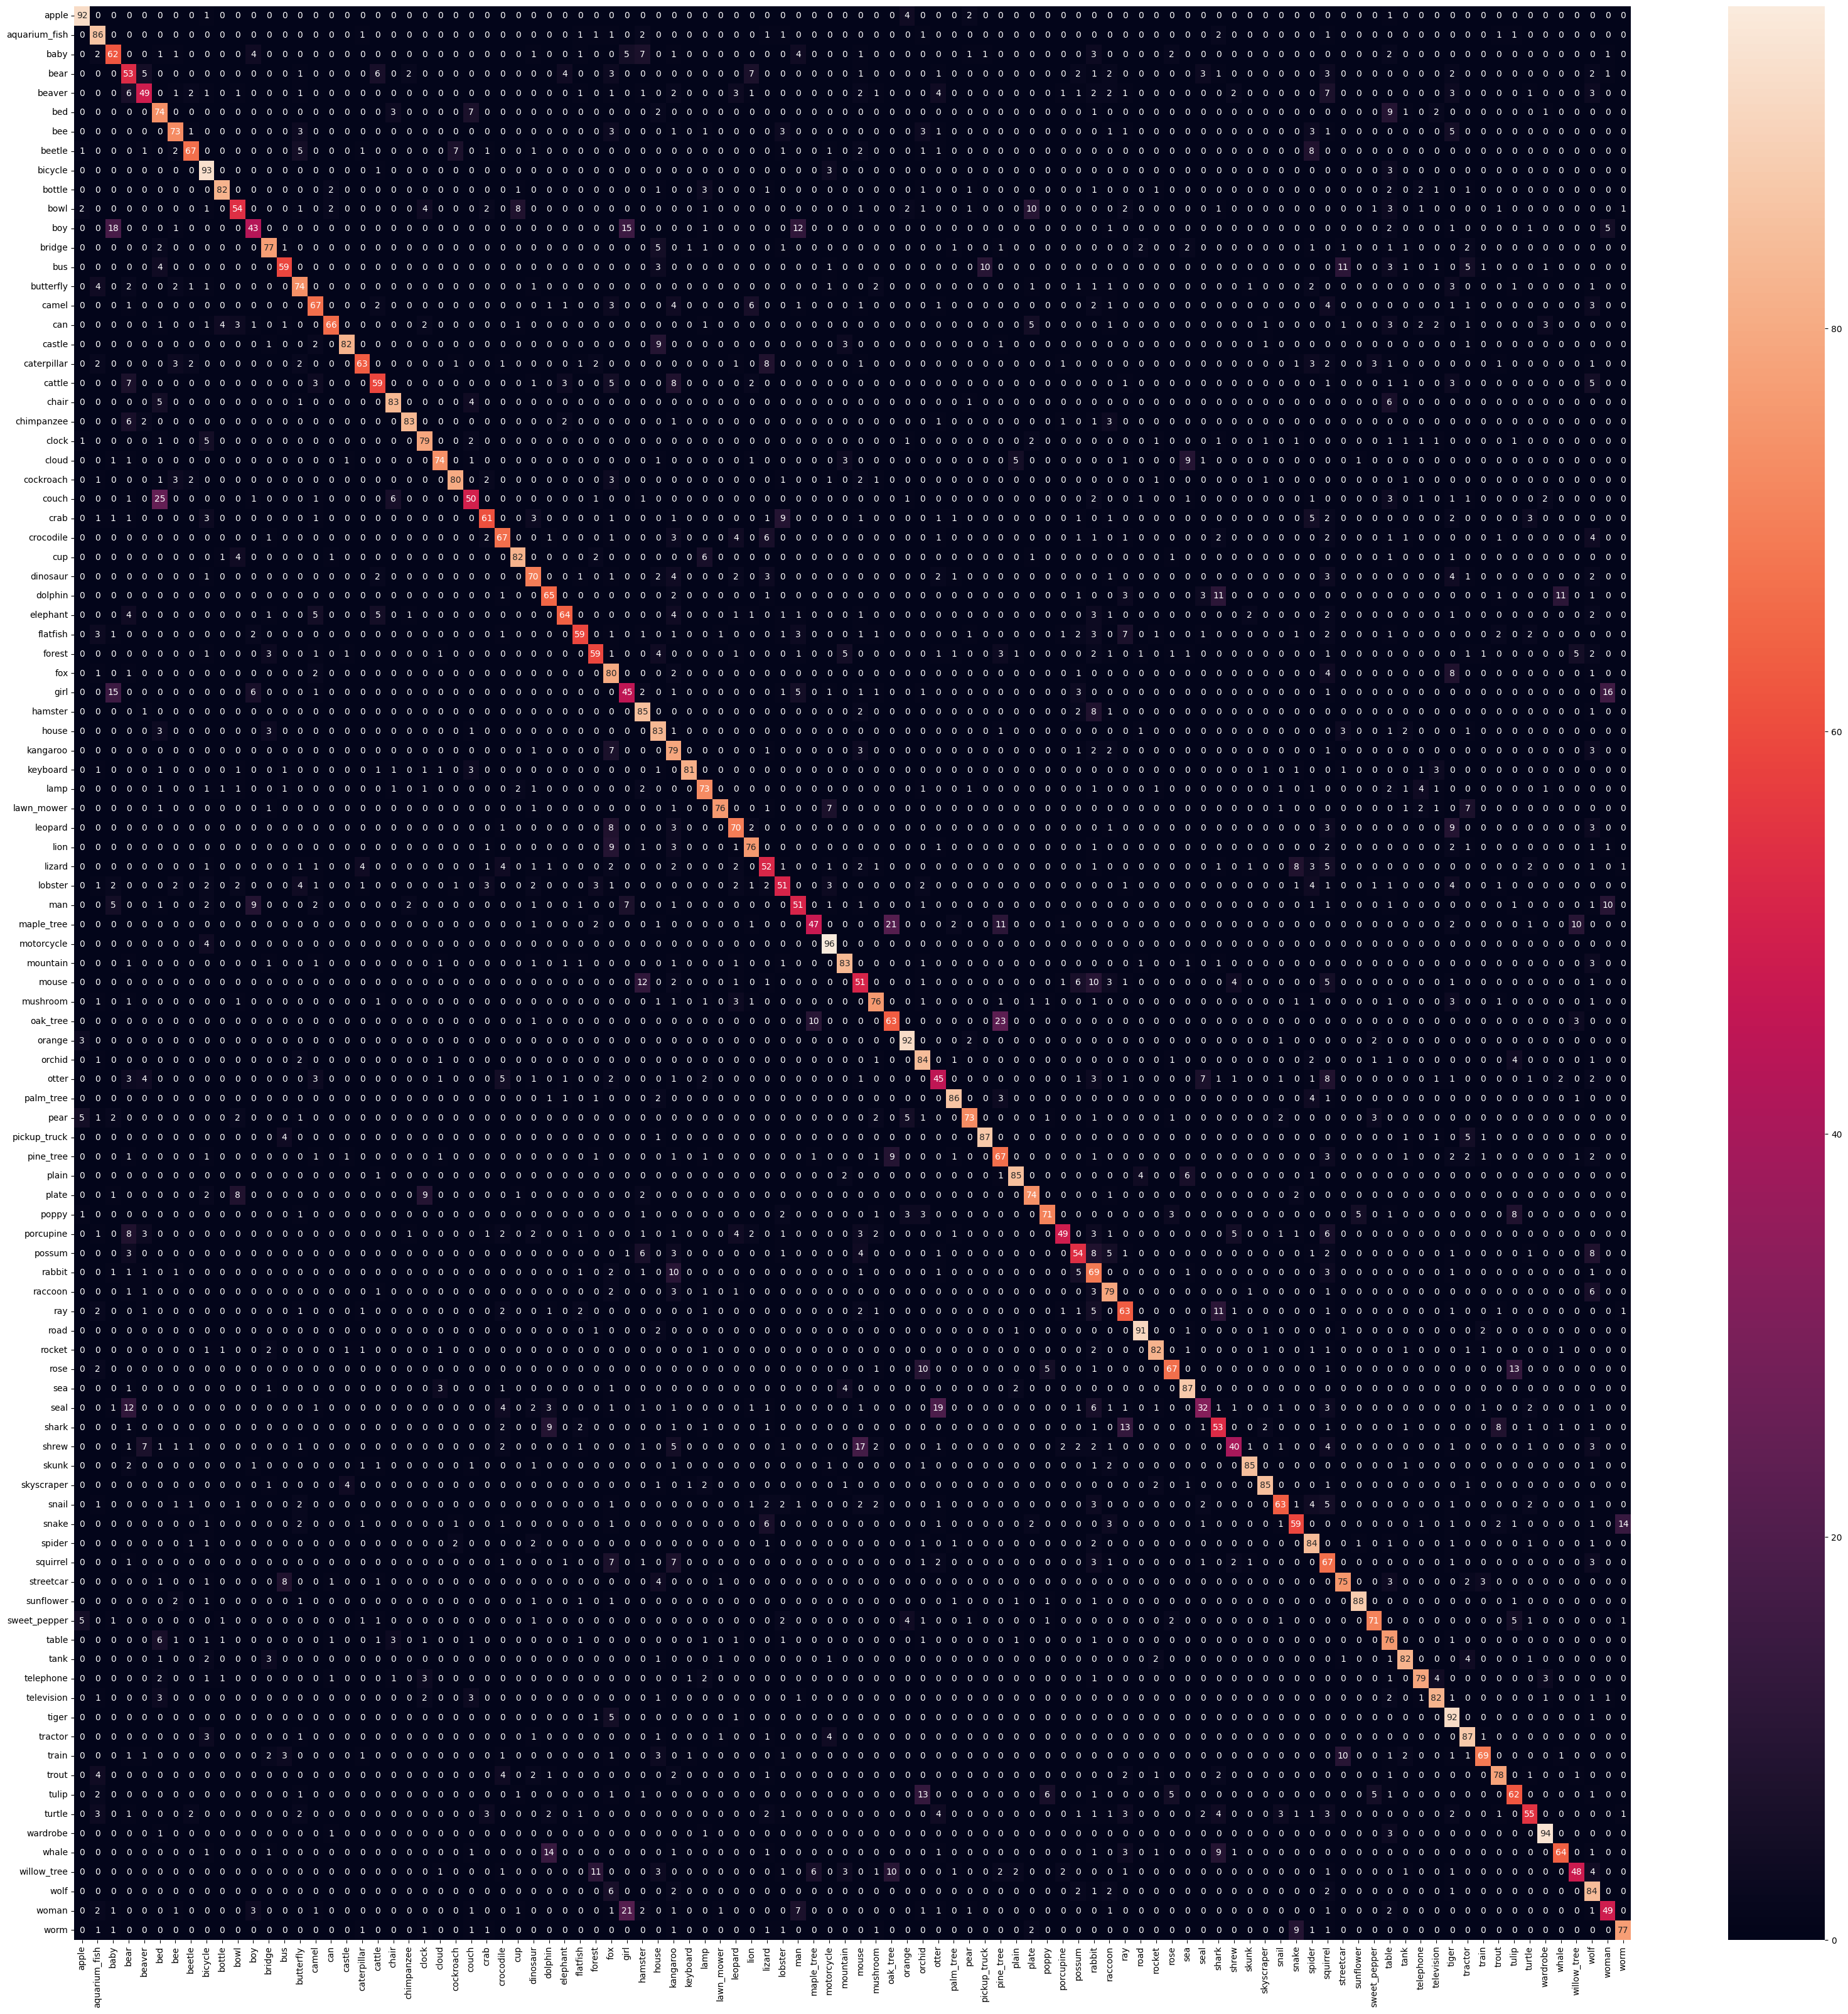

In [ ]:
cm = confusion_matrix(true_predictions, predictions_for_cm)
plt.figure(figsize=(40,40))
plot = sns.heatmap(cm, annot=True,  xticklabels=labels, yticklabels = labels)
fig = plot.get_figure()
fig.savefig("out.png")

**Once again an important output that should be downloaded**

The labels most difficult to distinguish are bear, man, otter, rabbit, seal, squirrel and woman. Is there anything that can be done to make their features more distinct to detect???

In [ ]:
# Ideas?

## Further evaluation metrics - to finish and adapt to this case

https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
# ROC curve was mentioned - what is it and how is it a good measure of the efficacy of a model?
# So it's TPR (y axis) vs FPR (x axis) - shows the best point of balance between between sensitivity (or TPR) and specificity (1 – FPR).
# Can be further explained by calculating the area under the curve - effective for comparison between classifiers
# Compute ROC curve and ROC area for each class
n_classes = 100
# classifier
clf = OneVsRestClassifier(LinearSVC(random_state=0))
y_score = clf.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Currently time after 10 epoch frozen and 5 epochs unfrozen is: 3652 secs = 60 mins and 52 secs
10 epochs frozen = 1432 secs = 23 mins and 52 secs
5 epochs unfrozen = 2220 secs = 37 mins

##Test Model 1 = DenseNet121 - **rather than like this just replace the VGG16 with the model name so that nothing else needs to be changed**
Selected due to lower size and parameters than baseline model but higher top1 and top5 accuracy likely due to the depth of the Model.

In [ ]:
test_model1 = keras.applications.DenseNet121(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(160,160,3),
                                        pooling='max')

test_model1.summary()

In [ ]:
out = test_model1.output
out = keras.layers.Flatten()(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(256, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(128, activation='relu')(out)
#out = keras.layers.Dropout(0.3)(out)
#out = keras.layers.BatchNormalization()(out)
#out = keras.layers.Dense(64, activation='relu')(out)
#out = keras.layers.Dropout(0.3)(out)
out = keras.layers.Dense(100, activation='softmax')(out) #key change is that there are 100 output nodes for the 100 classes

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar100.h5'

# callbacks
CALLBACKS.append(keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(keras.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(keras.callbacks.TensorBoard(log_dir='logs'))

model = keras.models.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_test, y_test),
                    callbacks=CALLBACKS)

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()
plt.savefig('Test1_model_accuracy.png')

##Test Model 2 = Xception

In [ ]:
test_model2 = keras.applications.Xception(include_top=False,
                                          weights='imagenet',
                                          input_tensor=upscale,
                                          input_shape=(160,160,3),
                                          pooling='max')

test_model2.summary()

In [ ]:
out = test_model2.output
out = keras.layers.Flatten()(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(256, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(128, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(64, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.Dense(100, activation='softmax')(out) #key change is that there are 100 output nodes for the 100 classes

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar100.h5'

# callbacks
CALLBACKS.append(keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(keras.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(keras.callbacks.TensorBoard(log_dir='logs'))

model = keras.models.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_test, y_test),
                    callbacks=CALLBACKS)

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()
plt.savefig('Test2_model_accuracy.png')

## Test Model 3 = ResNet101

In [ ]:
test_model3 = keras.applications.ResNet101(include_top=False,
                                          weights='imagenet',
                                          input_tensor=upscale,
                                          input_shape=(160,160,3),
                                          pooling='max')

test_model3.summary()

In [ ]:
out = test_model3.output
out = keras.layers.Flatten()(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(256, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(128, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(64, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.Dense(100, activation='softmax')(out) #key change is that there are 100 output nodes for the 100 classes

NameError: name 'base_model' is not defined

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar100.h5'

# callbacks
CALLBACKS.append(keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(keras.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(keras.callbacks.TensorBoard(log_dir='logs'))

model = keras.models.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_test, y_test),
                    callbacks=CALLBACKS)

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()
plt.savefig('Test3_model_accuracy.png')

##Test Model 4 = ResNet152

In [ ]:
test_model4 = keras.applications.ResNet152(include_top=False,
                                          weights='imagenet',
                                          input_tensor=upscale,
                                          input_shape=(160,160,3),
                                          pooling='max')

test_model4.summary()

In [ ]:
out = test_model4.output
out = keras.layers.Flatten()(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(256, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(128, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(64, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.Dense(100, activation='softmax')(out) #key change is that there are 100 output nodes for the 100 classes

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar100.h5'

# callbacks
CALLBACKS.append(keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(keras.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(keras.callbacks.TensorBoard(log_dir='logs'))

model = keras.models.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_test, y_test),
                    callbacks=CALLBACKS)

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()
plt.savefig('Test3_model_accuracy.png')